In [1]:
# Cell 1: Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score
import logging
import os
from datetime import datetime
import klib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import xgboost as xgb


In [2]:
# Cell 2: Setup Logging
class Logger:
    def __init__(self):
        self.logger = self.setup_logging()
    
    def setup_logging(self):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        log_file_name = f'training_{timestamp}.log'

        if os.path.exists('training.log'):
            os.remove('training.log')

        logger = logging.getLogger(__name__)
        logger.setLevel(logging.INFO)

        console_handler = logging.StreamHandler()
        file_handler = logging.FileHandler(log_file_name)

        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        console_handler.setFormatter(formatter)
        file_handler.setFormatter(formatter)

        logger.addHandler(console_handler)
        logger.addHandler(file_handler)
        return logger
    
    def info(self, message):
        self.logger.info(message)
    
    def error(self, message):
        self.logger.error(message)

logger = Logger()
logger.info("Setup and Imports complete.")


2024-07-14 15:58:20,157 - __main__ - INFO - Setup and Imports complete.


In [3]:
# Cell 3: Data Handling Class
class DataHandler:
    def __init__(self, logger):
        self.logger = logger

    def load_data(self, train_path, test_path):
        try:
            train_df = pd.read_csv(train_path)
            test_df = pd.read_csv(test_path)
            self.logger.info("Datasets loaded successfully.")
            return train_df, test_df
        except Exception as e:
            self.logger.error(f"Error loading datasets: {e}")
            return None, None

    def rename_columns(self, df, column_mapping):
        df.rename(columns=column_mapping, inplace=True)
        self.logger.info("Columns renamed.")
        return df

data_handler = DataHandler(logger)
train_df, test_df = data_handler.load_data("klib_full_trainset.csv", "klib_full_testset.csv")

# Ensure datasets are loaded correctly
if train_df is not None and test_df is not None:
    new_column_names = {
        'gender': 'Gender',
        'age': 'Age',
        'driving_license': 'Driving_License',
        'region_code': 'Region_Code',
        'previously_insured': 'Previously_Insured',
        'vehicle_age': 'Vehicle_Age',
        'vehicle_damage': 'Vehicle_Damage',
        'annual_premium': 'Annual_Premium',
        'policy_sales_channel': 'Policy_Sales_Channel',
        'vintage': 'Vintage',
        'response': 'Response'
    }

    train_df = data_handler.rename_columns(train_df, new_column_names)
    test_df = data_handler.rename_columns(test_df, new_column_names)

    # Split the data into training and validation sets before preprocessing
    X = train_df.drop(columns=['Response'])
    y = train_df['Response']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    logger.info(f"Training set shape: {X_train.shape}")
    logger.info(f"Validation set shape: {X_val.shape}")
else:
    raise ValueError("Failed to load datasets. Check the file paths and try again.")


2024-07-14 15:58:30,780 - __main__ - INFO - Datasets loaded successfully.
2024-07-14 15:58:30,781 - __main__ - INFO - Columns renamed.
2024-07-14 15:58:30,782 - __main__ - INFO - Columns renamed.
2024-07-14 15:58:35,275 - __main__ - INFO - Training set shape: (9172186, 9)
2024-07-14 15:58:35,276 - __main__ - INFO - Validation set shape: (2293047, 9)


In [4]:
# Cell 4: Feature Engineering Classes
class InteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Age_Annual_Premium'] = X['Age'] * X['Annual_Premium']
        X['Age_Vintage'] = X['Age'] * X['Vintage']
        X['Annual_Premium_Vintage'] = X['Annual_Premium'] * X['Vintage']
        X['Age_Region_Code'] = X['Age'] * X['Region_Code']
        X['Vintage_Region_Code'] = X['Vintage'] * X['Region_Code']
        X['Annual_Premium_Region_Code'] = X['Annual_Premium'] * X['Region_Code']
        self.feature_names = X.columns.tolist()
        return X

class PolynomialFeatureGeneration(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        self.feature_names = None

    def fit(self, X, y=None):
        self.poly.fit(X[['Age', 'Annual_Premium', 'Vintage']])
        return self

    def transform(self, X):
        poly_features = self.poly.transform(X[['Age', 'Annual_Premium', 'Vintage']])
        poly_feature_names = self.poly.get_feature_names_out(['Age', 'Annual_Premium', 'Vintage'])
        poly_df = pd.DataFrame(poly_features, columns=[f'poly_{name.replace(" ", "_")}' for name in poly_feature_names], index=X.index)
        X = pd.concat([X, poly_df], axis=1)
        self.feature_names = X.columns.tolist()
        return X

logger.info("Custom transformers defined.")


2024-07-14 15:58:35,286 - __main__ - INFO - Custom transformers defined.


In [5]:
# Cell 5: Preprocessing and Model Preparation
class PreprocessingPipeline:
    def __init__(self, logger):
        self.logger = logger
        self.pipeline = self.create_pipeline()

    def create_pipeline(self):
        pipeline = Pipeline([
            ('interactions', InteractionFeatures()),
            ('poly_features', PolynomialFeatureGeneration()),
            ('scaling', StandardScaler(with_mean=False))  # Preserve feature names
        ])
        self.logger.info("Preprocessing pipeline defined.")
        return pipeline

    def preprocess_data(self, X_train, X_val, y_train):
        X_train_preprocessed = self.pipeline.fit_transform(X_train, y_train)
        X_val_preprocessed = self.pipeline.transform(X_val)

        feature_names = self.pipeline.named_steps['poly_features'].feature_names
        X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
        X_val_preprocessed = pd.DataFrame(X_val_preprocessed, columns=feature_names)

        self.logger.info(f"Training set after preprocessing: {X_train_preprocessed.shape}")
        self.logger.info(f"Validation set after preprocessing: {X_val_preprocessed.shape}")
        return X_train_preprocessed, X_val_preprocessed

# Usage Example
preprocessor = PreprocessingPipeline(logger)
X_train_preprocessed, X_val_preprocessed = preprocessor.preprocess_data(X_train, X_val, y_train)

2024-07-14 15:58:35,292 - __main__ - INFO - Preprocessing pipeline defined.
2024-07-14 15:58:39,571 - __main__ - INFO - Training set after preprocessing: (9172186, 21)
2024-07-14 15:58:39,572 - __main__ - INFO - Validation set after preprocessing: (2293047, 21)


In [6]:
# Cell 6: Hyperparameter Optimization with Optuna
def objective(trial):
    param = {
        'eval_metric': 'auc',
        'early_stopping_rounds': 100,
        'lambda': trial.suggest_float('lambda', 1e-4, 0.01, log=True),  # Narrowed range based on findings
        'alpha': trial.suggest_float('alpha', 0.01, 1.0, log=True),  # Focused range based on findings
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.7, 0.8, 0.9, 1.0]),  # Focus on higher values
        'subsample': trial.suggest_categorical('subsample', [0.7, 0.8, 1.0]),  # Focus on higher values
        'learning_rate': trial.suggest_categorical('learning_rate', [0.012, 0.014, 0.016]),  # Focused range
        'n_estimators': trial.suggest_int('n_estimators', 700, 1000),  # Higher range
        'max_depth': trial.suggest_categorical('max_depth', [13, 15, 17]),  # Focus on higher values
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 150, 300),  # Higher range based on findings
    }
    
    y_train_series = pd.Series(y_train)  # Convert y_train to pandas Series
    ratio = float(y_train_series.value_counts()[0]) / y_train_series.value_counts()[1]
    model = xgb.XGBClassifier(**param, scale_pos_weight=ratio)
    
    model.fit(
        X_train_preprocessed, y_train_series,
        eval_set=[(X_val_preprocessed, y_val)],
        verbose=True
    )
    
    y_pred = model.predict_proba(X_val_preprocessed)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    return auc

logger.info("Starting hyperparameter optimization with Optuna.")
# Generate a unique filename for each run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sqlite_file_path = os.path.join(r'C:\Users\paulo\OneDrive\Documents\Binary-Classification-of-Insurance-Cross-Selling\model testing\xgboost\featured engineered', f'optuna_study_{timestamp}.db')

study = optuna.create_study(storage=f'sqlite:///{sqlite_file_path}', study_name=f'my_study_{timestamp}', direction='maximize')
study.optimize(objective, n_trials=25)  # Increased number of trials

logger.info(f"Best trial parameters: {study.best_trial.params}")
logger.info(f"Best trial AUC: {study.best_trial.value}")


2024-07-14 15:58:39,580 - __main__ - INFO - Starting hyperparameter optimization with Optuna.
[I 2024-07-14 15:58:40,070] A new study created in RDB with name: my_study_20240714_155839


[0]	validation_0-auc:0.85586
[1]	validation_0-auc:0.86361
[2]	validation_0-auc:0.86451
[3]	validation_0-auc:0.86385
[4]	validation_0-auc:0.86497
[5]	validation_0-auc:0.86519
[6]	validation_0-auc:0.86590
[7]	validation_0-auc:0.86567
[8]	validation_0-auc:0.86599
[9]	validation_0-auc:0.86599
[10]	validation_0-auc:0.86625
[11]	validation_0-auc:0.86628
[12]	validation_0-auc:0.86654
[13]	validation_0-auc:0.86659
[14]	validation_0-auc:0.86670
[15]	validation_0-auc:0.86665
[16]	validation_0-auc:0.86670
[17]	validation_0-auc:0.86683
[18]	validation_0-auc:0.86690
[19]	validation_0-auc:0.86692
[20]	validation_0-auc:0.86694
[21]	validation_0-auc:0.86713
[22]	validation_0-auc:0.86716
[23]	validation_0-auc:0.86716
[24]	validation_0-auc:0.86716
[25]	validation_0-auc:0.86715
[26]	validation_0-auc:0.86719
[27]	validation_0-auc:0.86706
[28]	validation_0-auc:0.86711
[29]	validation_0-auc:0.86716
[30]	validation_0-auc:0.86726
[31]	validation_0-auc:0.86727
[32]	validation_0-auc:0.86730
[33]	validation_0-au

[I 2024-07-14 16:09:01,713] Trial 0 finished with value: 0.8800951463635575 and parameters: {'lambda': 0.002412636382542979, 'alpha': 0.3914582374141435, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 700, 'max_depth': 13, 'min_child_weight': 216}. Best is trial 0 with value: 0.8800951463635575.


[0]	validation_0-auc:0.85848
[1]	validation_0-auc:0.86579
[2]	validation_0-auc:0.86672
[3]	validation_0-auc:0.86607
[4]	validation_0-auc:0.86726
[5]	validation_0-auc:0.86754
[6]	validation_0-auc:0.86820
[7]	validation_0-auc:0.86791
[8]	validation_0-auc:0.86828
[9]	validation_0-auc:0.86831
[10]	validation_0-auc:0.86865
[11]	validation_0-auc:0.86873
[12]	validation_0-auc:0.86898
[13]	validation_0-auc:0.86915
[14]	validation_0-auc:0.86927
[15]	validation_0-auc:0.86927
[16]	validation_0-auc:0.86933
[17]	validation_0-auc:0.86944
[18]	validation_0-auc:0.86951
[19]	validation_0-auc:0.86954
[20]	validation_0-auc:0.86957
[21]	validation_0-auc:0.86968
[22]	validation_0-auc:0.86968
[23]	validation_0-auc:0.86970
[24]	validation_0-auc:0.86972
[25]	validation_0-auc:0.86970
[26]	validation_0-auc:0.86974
[27]	validation_0-auc:0.86963
[28]	validation_0-auc:0.86965
[29]	validation_0-auc:0.86971
[30]	validation_0-auc:0.86980
[31]	validation_0-auc:0.86980
[32]	validation_0-auc:0.86984
[33]	validation_0-au

[I 2024-07-14 16:21:36,528] Trial 1 finished with value: 0.8809187847460419 and parameters: {'lambda': 0.007863054439179134, 'alpha': 0.16595131851040737, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 790, 'max_depth': 15, 'min_child_weight': 202}. Best is trial 1 with value: 0.8809187847460419.


[0]	validation_0-auc:0.86050
[1]	validation_0-auc:0.86736
[2]	validation_0-auc:0.86929
[3]	validation_0-auc:0.86897
[4]	validation_0-auc:0.86962
[5]	validation_0-auc:0.86991
[6]	validation_0-auc:0.86990
[7]	validation_0-auc:0.86985
[8]	validation_0-auc:0.87002
[9]	validation_0-auc:0.87014
[10]	validation_0-auc:0.87019
[11]	validation_0-auc:0.87022
[12]	validation_0-auc:0.87021
[13]	validation_0-auc:0.87022
[14]	validation_0-auc:0.87020
[15]	validation_0-auc:0.87025
[16]	validation_0-auc:0.87035
[17]	validation_0-auc:0.87036
[18]	validation_0-auc:0.87035
[19]	validation_0-auc:0.87041
[20]	validation_0-auc:0.87041
[21]	validation_0-auc:0.87041
[22]	validation_0-auc:0.87041
[23]	validation_0-auc:0.87044
[24]	validation_0-auc:0.87047
[25]	validation_0-auc:0.87052
[26]	validation_0-auc:0.87051
[27]	validation_0-auc:0.87067
[28]	validation_0-auc:0.87070
[29]	validation_0-auc:0.87071
[30]	validation_0-auc:0.87074
[31]	validation_0-auc:0.87075
[32]	validation_0-auc:0.87074
[33]	validation_0-au

[I 2024-07-14 16:34:39,002] Trial 2 finished with value: 0.8804505712063304 and parameters: {'lambda': 0.002726946118230199, 'alpha': 0.04145339781253624, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 730, 'max_depth': 17, 'min_child_weight': 186}. Best is trial 1 with value: 0.8809187847460419.


[0]	validation_0-auc:0.86057
[1]	validation_0-auc:0.86794
[2]	validation_0-auc:0.86888
[3]	validation_0-auc:0.86811
[4]	validation_0-auc:0.86939
[5]	validation_0-auc:0.86973
[6]	validation_0-auc:0.87022
[7]	validation_0-auc:0.86991
[8]	validation_0-auc:0.87029
[9]	validation_0-auc:0.87037
[10]	validation_0-auc:0.87060
[11]	validation_0-auc:0.87069
[12]	validation_0-auc:0.87089
[13]	validation_0-auc:0.87102
[14]	validation_0-auc:0.87117
[15]	validation_0-auc:0.87120
[16]	validation_0-auc:0.87121
[17]	validation_0-auc:0.87131
[18]	validation_0-auc:0.87137
[19]	validation_0-auc:0.87138
[20]	validation_0-auc:0.87142
[21]	validation_0-auc:0.87153
[22]	validation_0-auc:0.87156
[23]	validation_0-auc:0.87158
[24]	validation_0-auc:0.87159
[25]	validation_0-auc:0.87157
[26]	validation_0-auc:0.87162
[27]	validation_0-auc:0.87150
[28]	validation_0-auc:0.87154
[29]	validation_0-auc:0.87160
[30]	validation_0-auc:0.87171
[31]	validation_0-auc:0.87171
[32]	validation_0-auc:0.87175
[33]	validation_0-au

[I 2024-07-14 16:48:33,276] Trial 3 finished with value: 0.8808572403935503 and parameters: {'lambda': 0.00993378165392168, 'alpha': 0.04976988293697782, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 773, 'max_depth': 17, 'min_child_weight': 202}. Best is trial 1 with value: 0.8809187847460419.


[0]	validation_0-auc:0.86054
[1]	validation_0-auc:0.86747
[2]	validation_0-auc:0.86895
[3]	validation_0-auc:0.86883
[4]	validation_0-auc:0.86942
[5]	validation_0-auc:0.87002
[6]	validation_0-auc:0.86999
[7]	validation_0-auc:0.86980
[8]	validation_0-auc:0.87007
[9]	validation_0-auc:0.87021
[10]	validation_0-auc:0.87020
[11]	validation_0-auc:0.87048
[12]	validation_0-auc:0.87051
[13]	validation_0-auc:0.87066
[14]	validation_0-auc:0.87066
[15]	validation_0-auc:0.87094
[16]	validation_0-auc:0.87105
[17]	validation_0-auc:0.87115
[18]	validation_0-auc:0.87119
[19]	validation_0-auc:0.87117
[20]	validation_0-auc:0.87119
[21]	validation_0-auc:0.87120
[22]	validation_0-auc:0.87117
[23]	validation_0-auc:0.87133
[24]	validation_0-auc:0.87129
[25]	validation_0-auc:0.87133
[26]	validation_0-auc:0.87134
[27]	validation_0-auc:0.87145
[28]	validation_0-auc:0.87150
[29]	validation_0-auc:0.87150
[30]	validation_0-auc:0.87155
[31]	validation_0-auc:0.87154
[32]	validation_0-auc:0.87154
[33]	validation_0-au

[I 2024-07-14 17:03:20,667] Trial 4 finished with value: 0.8807958683084828 and parameters: {'lambda': 0.000204745399516327, 'alpha': 0.34210963014210904, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 884, 'max_depth': 17, 'min_child_weight': 236}. Best is trial 1 with value: 0.8809187847460419.


[0]	validation_0-auc:0.86232
[1]	validation_0-auc:0.86286
[2]	validation_0-auc:0.86301
[3]	validation_0-auc:0.86310
[4]	validation_0-auc:0.86325
[5]	validation_0-auc:0.86380
[6]	validation_0-auc:0.86380
[7]	validation_0-auc:0.86405
[8]	validation_0-auc:0.86411
[9]	validation_0-auc:0.86412
[10]	validation_0-auc:0.86411
[11]	validation_0-auc:0.86411
[12]	validation_0-auc:0.86410
[13]	validation_0-auc:0.86410
[14]	validation_0-auc:0.86423
[15]	validation_0-auc:0.86426
[16]	validation_0-auc:0.86427
[17]	validation_0-auc:0.86430
[18]	validation_0-auc:0.86447
[19]	validation_0-auc:0.86456
[20]	validation_0-auc:0.86460
[21]	validation_0-auc:0.86474
[22]	validation_0-auc:0.86475
[23]	validation_0-auc:0.86476
[24]	validation_0-auc:0.86479
[25]	validation_0-auc:0.86482
[26]	validation_0-auc:0.86489
[27]	validation_0-auc:0.86494
[28]	validation_0-auc:0.86493
[29]	validation_0-auc:0.86495
[30]	validation_0-auc:0.86501
[31]	validation_0-auc:0.86504
[32]	validation_0-auc:0.86510
[33]	validation_0-au

[I 2024-07-14 17:17:24,280] Trial 5 finished with value: 0.8809002928269001 and parameters: {'lambda': 0.0007186217148523188, 'alpha': 0.22166402751824635, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 952, 'max_depth': 13, 'min_child_weight': 195}. Best is trial 1 with value: 0.8809187847460419.


[0]	validation_0-auc:0.86467
[1]	validation_0-auc:0.86478
[2]	validation_0-auc:0.86496
[3]	validation_0-auc:0.86508
[4]	validation_0-auc:0.86518
[5]	validation_0-auc:0.86523
[6]	validation_0-auc:0.86527
[7]	validation_0-auc:0.86535
[8]	validation_0-auc:0.86541
[9]	validation_0-auc:0.86556
[10]	validation_0-auc:0.86565
[11]	validation_0-auc:0.86573
[12]	validation_0-auc:0.86604
[13]	validation_0-auc:0.86624
[14]	validation_0-auc:0.86627
[15]	validation_0-auc:0.86643
[16]	validation_0-auc:0.86662
[17]	validation_0-auc:0.86668
[18]	validation_0-auc:0.86678
[19]	validation_0-auc:0.86683
[20]	validation_0-auc:0.86691
[21]	validation_0-auc:0.86694
[22]	validation_0-auc:0.86699
[23]	validation_0-auc:0.86701
[24]	validation_0-auc:0.86705
[25]	validation_0-auc:0.86708
[26]	validation_0-auc:0.86711
[27]	validation_0-auc:0.86714
[28]	validation_0-auc:0.86715
[29]	validation_0-auc:0.86716
[30]	validation_0-auc:0.86718
[31]	validation_0-auc:0.86722
[32]	validation_0-auc:0.86723
[33]	validation_0-au

[I 2024-07-14 17:30:55,742] Trial 6 finished with value: 0.8808749165641121 and parameters: {'lambda': 0.00036570287739947374, 'alpha': 0.8119337241716928, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 917, 'max_depth': 15, 'min_child_weight': 259}. Best is trial 1 with value: 0.8809187847460419.


[0]	validation_0-auc:0.85832
[1]	validation_0-auc:0.86586
[2]	validation_0-auc:0.86682
[3]	validation_0-auc:0.86610
[4]	validation_0-auc:0.86724
[5]	validation_0-auc:0.86750
[6]	validation_0-auc:0.86807
[7]	validation_0-auc:0.86780
[8]	validation_0-auc:0.86820
[9]	validation_0-auc:0.86828
[10]	validation_0-auc:0.86850
[11]	validation_0-auc:0.86854
[12]	validation_0-auc:0.86881
[13]	validation_0-auc:0.86889
[14]	validation_0-auc:0.86904
[15]	validation_0-auc:0.86905
[16]	validation_0-auc:0.86904
[17]	validation_0-auc:0.86919
[18]	validation_0-auc:0.86926
[19]	validation_0-auc:0.86927
[20]	validation_0-auc:0.86930
[21]	validation_0-auc:0.86948
[22]	validation_0-auc:0.86951
[23]	validation_0-auc:0.86951
[24]	validation_0-auc:0.86953
[25]	validation_0-auc:0.86951
[26]	validation_0-auc:0.86955
[27]	validation_0-auc:0.86944
[28]	validation_0-auc:0.86948
[29]	validation_0-auc:0.86955
[30]	validation_0-auc:0.86966
[31]	validation_0-auc:0.86967
[32]	validation_0-auc:0.86972
[33]	validation_0-au

[I 2024-07-14 17:46:50,081] Trial 7 finished with value: 0.8810727509504557 and parameters: {'lambda': 0.00869249246260358, 'alpha': 0.1406613877593707, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 960, 'max_depth': 15, 'min_child_weight': 208}. Best is trial 7 with value: 0.8810727509504557.


[0]	validation_0-auc:0.86049
[1]	validation_0-auc:0.86734
[2]	validation_0-auc:0.86929
[3]	validation_0-auc:0.86896
[4]	validation_0-auc:0.86960
[5]	validation_0-auc:0.87002
[6]	validation_0-auc:0.87003
[7]	validation_0-auc:0.86996
[8]	validation_0-auc:0.87023
[9]	validation_0-auc:0.87029
[10]	validation_0-auc:0.87034
[11]	validation_0-auc:0.87061
[12]	validation_0-auc:0.87062
[13]	validation_0-auc:0.87080
[14]	validation_0-auc:0.87076
[15]	validation_0-auc:0.87092
[16]	validation_0-auc:0.87102
[17]	validation_0-auc:0.87105
[18]	validation_0-auc:0.87105
[19]	validation_0-auc:0.87105
[20]	validation_0-auc:0.87113
[21]	validation_0-auc:0.87114
[22]	validation_0-auc:0.87110
[23]	validation_0-auc:0.87126
[24]	validation_0-auc:0.87124
[25]	validation_0-auc:0.87128
[26]	validation_0-auc:0.87129
[27]	validation_0-auc:0.87134
[28]	validation_0-auc:0.87139
[29]	validation_0-auc:0.87140
[30]	validation_0-auc:0.87145
[31]	validation_0-auc:0.87145
[32]	validation_0-auc:0.87145
[33]	validation_0-au

[I 2024-07-14 18:03:46,592] Trial 8 finished with value: 0.8809585599799453 and parameters: {'lambda': 0.00033986826654001717, 'alpha': 0.012405316055592606, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 939, 'max_depth': 17, 'min_child_weight': 180}. Best is trial 7 with value: 0.8810727509504557.


[0]	validation_0-auc:0.86073
[1]	validation_0-auc:0.86734
[2]	validation_0-auc:0.86917
[3]	validation_0-auc:0.86879
[4]	validation_0-auc:0.86937
[5]	validation_0-auc:0.86978
[6]	validation_0-auc:0.86981
[7]	validation_0-auc:0.86973
[8]	validation_0-auc:0.86996
[9]	validation_0-auc:0.87002
[10]	validation_0-auc:0.87008
[11]	validation_0-auc:0.87036
[12]	validation_0-auc:0.87037
[13]	validation_0-auc:0.87057
[14]	validation_0-auc:0.87053
[15]	validation_0-auc:0.87068
[16]	validation_0-auc:0.87079
[17]	validation_0-auc:0.87082
[18]	validation_0-auc:0.87083
[19]	validation_0-auc:0.87084
[20]	validation_0-auc:0.87092
[21]	validation_0-auc:0.87093
[22]	validation_0-auc:0.87090
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87102
[25]	validation_0-auc:0.87105
[26]	validation_0-auc:0.87106
[27]	validation_0-auc:0.87116
[28]	validation_0-auc:0.87122
[29]	validation_0-auc:0.87123
[30]	validation_0-auc:0.87128
[31]	validation_0-auc:0.87129
[32]	validation_0-auc:0.87129
[33]	validation_0-au

[I 2024-07-14 18:20:51,868] Trial 9 finished with value: 0.8811275290058734 and parameters: {'lambda': 0.005568560297902326, 'alpha': 0.37007534586338875, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 978, 'max_depth': 17, 'min_child_weight': 297}. Best is trial 9 with value: 0.8811275290058734.


[0]	validation_0-auc:0.86075
[1]	validation_0-auc:0.86735
[2]	validation_0-auc:0.86918
[3]	validation_0-auc:0.86879
[4]	validation_0-auc:0.86937
[5]	validation_0-auc:0.86977
[6]	validation_0-auc:0.86978
[7]	validation_0-auc:0.86971
[8]	validation_0-auc:0.86995
[9]	validation_0-auc:0.87001
[10]	validation_0-auc:0.87006
[11]	validation_0-auc:0.87034
[12]	validation_0-auc:0.87036
[13]	validation_0-auc:0.87055
[14]	validation_0-auc:0.87051
[15]	validation_0-auc:0.87066
[16]	validation_0-auc:0.87077
[17]	validation_0-auc:0.87081
[18]	validation_0-auc:0.87081
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87090
[21]	validation_0-auc:0.87091
[22]	validation_0-auc:0.87089
[23]	validation_0-auc:0.87104
[24]	validation_0-auc:0.87101
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87106
[27]	validation_0-auc:0.87115
[28]	validation_0-auc:0.87121
[29]	validation_0-auc:0.87122
[30]	validation_0-auc:0.87127
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87128
[33]	validation_0-au

[I 2024-07-14 18:38:52,279] Trial 10 finished with value: 0.8811344455099226 and parameters: {'lambda': 0.002059927973781217, 'alpha': 0.8890419251504416, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 990, 'max_depth': 17, 'min_child_weight': 299}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86075
[1]	validation_0-auc:0.86735
[2]	validation_0-auc:0.86918
[3]	validation_0-auc:0.86879
[4]	validation_0-auc:0.86937
[5]	validation_0-auc:0.86976
[6]	validation_0-auc:0.86978
[7]	validation_0-auc:0.86970
[8]	validation_0-auc:0.86994
[9]	validation_0-auc:0.87000
[10]	validation_0-auc:0.87005
[11]	validation_0-auc:0.87033
[12]	validation_0-auc:0.87035
[13]	validation_0-auc:0.87055
[14]	validation_0-auc:0.87050
[15]	validation_0-auc:0.87066
[16]	validation_0-auc:0.87076
[17]	validation_0-auc:0.87080
[18]	validation_0-auc:0.87080
[19]	validation_0-auc:0.87081
[20]	validation_0-auc:0.87089
[21]	validation_0-auc:0.87091
[22]	validation_0-auc:0.87088
[23]	validation_0-auc:0.87104
[24]	validation_0-auc:0.87100
[25]	validation_0-auc:0.87103
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87114
[28]	validation_0-auc:0.87120
[29]	validation_0-auc:0.87121
[30]	validation_0-auc:0.87126
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87127
[33]	validation_0-au

[I 2024-07-14 18:57:54,421] Trial 11 finished with value: 0.8811200149157757 and parameters: {'lambda': 0.002647909677759611, 'alpha': 0.9642456692141522, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 997, 'max_depth': 17, 'min_child_weight': 300}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86074
[1]	validation_0-auc:0.86734
[2]	validation_0-auc:0.86917
[3]	validation_0-auc:0.86878
[4]	validation_0-auc:0.86936
[5]	validation_0-auc:0.86976
[6]	validation_0-auc:0.86978
[7]	validation_0-auc:0.86971
[8]	validation_0-auc:0.86994
[9]	validation_0-auc:0.87000
[10]	validation_0-auc:0.87006
[11]	validation_0-auc:0.87034
[12]	validation_0-auc:0.87036
[13]	validation_0-auc:0.87056
[14]	validation_0-auc:0.87051
[15]	validation_0-auc:0.87066
[16]	validation_0-auc:0.87077
[17]	validation_0-auc:0.87080
[18]	validation_0-auc:0.87081
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87090
[21]	validation_0-auc:0.87091
[22]	validation_0-auc:0.87089
[23]	validation_0-auc:0.87104
[24]	validation_0-auc:0.87101
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87115
[28]	validation_0-auc:0.87121
[29]	validation_0-auc:0.87122
[30]	validation_0-auc:0.87127
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87128
[33]	validation_0-au

[I 2024-07-14 19:17:37,516] Trial 12 finished with value: 0.8811315239187154 and parameters: {'lambda': 0.0014429444652365377, 'alpha': 0.522356526214194, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 997, 'max_depth': 17, 'min_child_weight': 300}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86073
[1]	validation_0-auc:0.86737
[2]	validation_0-auc:0.86920
[3]	validation_0-auc:0.86883
[4]	validation_0-auc:0.86944
[5]	validation_0-auc:0.86985
[6]	validation_0-auc:0.86986
[7]	validation_0-auc:0.86978
[8]	validation_0-auc:0.87003
[9]	validation_0-auc:0.87009
[10]	validation_0-auc:0.87015
[11]	validation_0-auc:0.87043
[12]	validation_0-auc:0.87044
[13]	validation_0-auc:0.87063
[14]	validation_0-auc:0.87059
[15]	validation_0-auc:0.87074
[16]	validation_0-auc:0.87084
[17]	validation_0-auc:0.87088
[18]	validation_0-auc:0.87089
[19]	validation_0-auc:0.87090
[20]	validation_0-auc:0.87097
[21]	validation_0-auc:0.87099
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87112
[24]	validation_0-auc:0.87109
[25]	validation_0-auc:0.87112
[26]	validation_0-auc:0.87114
[27]	validation_0-auc:0.87120
[28]	validation_0-auc:0.87126
[29]	validation_0-auc:0.87127
[30]	validation_0-auc:0.87133
[31]	validation_0-auc:0.87133
[32]	validation_0-auc:0.87134
[33]	validation_0-au

[I 2024-07-14 19:43:06,136] Trial 13 finished with value: 0.881060637906835 and parameters: {'lambda': 0.0012469503815084018, 'alpha': 0.6394541859917033, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 853, 'max_depth': 17, 'min_child_weight': 269}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86039
[1]	validation_0-auc:0.86734
[2]	validation_0-auc:0.86924
[3]	validation_0-auc:0.86895
[4]	validation_0-auc:0.86960
[5]	validation_0-auc:0.86992
[6]	validation_0-auc:0.86991
[7]	validation_0-auc:0.86988
[8]	validation_0-auc:0.87004
[9]	validation_0-auc:0.87016
[10]	validation_0-auc:0.87021
[11]	validation_0-auc:0.87023
[12]	validation_0-auc:0.87022
[13]	validation_0-auc:0.87024
[14]	validation_0-auc:0.87022
[15]	validation_0-auc:0.87027
[16]	validation_0-auc:0.87037
[17]	validation_0-auc:0.87038
[18]	validation_0-auc:0.87037
[19]	validation_0-auc:0.87037
[20]	validation_0-auc:0.87037
[21]	validation_0-auc:0.87038
[22]	validation_0-auc:0.87039
[23]	validation_0-auc:0.87042
[24]	validation_0-auc:0.87046
[25]	validation_0-auc:0.87051
[26]	validation_0-auc:0.87050
[27]	validation_0-auc:0.87067
[28]	validation_0-auc:0.87071
[29]	validation_0-auc:0.87071
[30]	validation_0-auc:0.87075
[31]	validation_0-auc:0.87076
[32]	validation_0-auc:0.87074
[33]	validation_0-au

[I 2024-07-14 20:01:31,382] Trial 14 finished with value: 0.8807642231068303 and parameters: {'lambda': 0.0010276915076932974, 'alpha': 0.08476175269379053, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 903, 'max_depth': 17, 'min_child_weight': 151}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.85616
[1]	validation_0-auc:0.86350
[2]	validation_0-auc:0.86499
[3]	validation_0-auc:0.86486
[4]	validation_0-auc:0.86531
[5]	validation_0-auc:0.86588
[6]	validation_0-auc:0.86581
[7]	validation_0-auc:0.86580
[8]	validation_0-auc:0.86600
[9]	validation_0-auc:0.86603
[10]	validation_0-auc:0.86609
[11]	validation_0-auc:0.86638
[12]	validation_0-auc:0.86639
[13]	validation_0-auc:0.86656
[14]	validation_0-auc:0.86654
[15]	validation_0-auc:0.86674
[16]	validation_0-auc:0.86689
[17]	validation_0-auc:0.86695
[18]	validation_0-auc:0.86694
[19]	validation_0-auc:0.86691
[20]	validation_0-auc:0.86689
[21]	validation_0-auc:0.86688
[22]	validation_0-auc:0.86683
[23]	validation_0-auc:0.86696
[24]	validation_0-auc:0.86693
[25]	validation_0-auc:0.86695
[26]	validation_0-auc:0.86694
[27]	validation_0-auc:0.86711
[28]	validation_0-auc:0.86715
[29]	validation_0-auc:0.86714
[30]	validation_0-auc:0.86718
[31]	validation_0-auc:0.86716
[32]	validation_0-auc:0.86714
[33]	validation_0-au

[I 2024-07-14 20:14:33,712] Trial 15 finished with value: 0.8808233652973447 and parameters: {'lambda': 0.00010039879662165496, 'alpha': 0.517508749932239, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 856, 'max_depth': 13, 'min_child_weight': 278}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86057
[1]	validation_0-auc:0.86733
[2]	validation_0-auc:0.86920
[3]	validation_0-auc:0.86883
[4]	validation_0-auc:0.86945
[5]	validation_0-auc:0.86987
[6]	validation_0-auc:0.86988
[7]	validation_0-auc:0.86981
[8]	validation_0-auc:0.87006
[9]	validation_0-auc:0.87013
[10]	validation_0-auc:0.87019
[11]	validation_0-auc:0.87046
[12]	validation_0-auc:0.87048
[13]	validation_0-auc:0.87067
[14]	validation_0-auc:0.87063
[15]	validation_0-auc:0.87079
[16]	validation_0-auc:0.87089
[17]	validation_0-auc:0.87093
[18]	validation_0-auc:0.87094
[19]	validation_0-auc:0.87095
[20]	validation_0-auc:0.87103
[21]	validation_0-auc:0.87104
[22]	validation_0-auc:0.87103
[23]	validation_0-auc:0.87118
[24]	validation_0-auc:0.87115
[25]	validation_0-auc:0.87119
[26]	validation_0-auc:0.87120
[27]	validation_0-auc:0.87130
[28]	validation_0-auc:0.87135
[29]	validation_0-auc:0.87136
[30]	validation_0-auc:0.87141
[31]	validation_0-auc:0.87141
[32]	validation_0-auc:0.87141
[33]	validation_0-au

[I 2024-07-14 20:33:58,717] Trial 16 finished with value: 0.8811025387128522 and parameters: {'lambda': 0.0016741522335431832, 'alpha': 0.012180030341577592, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 997, 'max_depth': 17, 'min_child_weight': 252}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86075
[1]	validation_0-auc:0.86737
[2]	validation_0-auc:0.86920
[3]	validation_0-auc:0.86883
[4]	validation_0-auc:0.86941
[5]	validation_0-auc:0.86982
[6]	validation_0-auc:0.86983
[7]	validation_0-auc:0.86976
[8]	validation_0-auc:0.86999
[9]	validation_0-auc:0.87006
[10]	validation_0-auc:0.87012
[11]	validation_0-auc:0.87039
[12]	validation_0-auc:0.87041
[13]	validation_0-auc:0.87060
[14]	validation_0-auc:0.87056
[15]	validation_0-auc:0.87072
[16]	validation_0-auc:0.87082
[17]	validation_0-auc:0.87086
[18]	validation_0-auc:0.87086
[19]	validation_0-auc:0.87087
[20]	validation_0-auc:0.87095
[21]	validation_0-auc:0.87096
[22]	validation_0-auc:0.87094
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87106
[25]	validation_0-auc:0.87109
[26]	validation_0-auc:0.87111
[27]	validation_0-auc:0.87121
[28]	validation_0-auc:0.87126
[29]	validation_0-auc:0.87127
[30]	validation_0-auc:0.87133
[31]	validation_0-auc:0.87133
[32]	validation_0-auc:0.87134
[33]	validation_0-au

[I 2024-07-14 20:49:44,247] Trial 17 finished with value: 0.8810009766799889 and parameters: {'lambda': 0.0006528505083684724, 'alpha': 0.9929315067736645, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 805, 'max_depth': 17, 'min_child_weight': 278}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86236
[1]	validation_0-auc:0.86285
[2]	validation_0-auc:0.86299
[3]	validation_0-auc:0.86313
[4]	validation_0-auc:0.86326
[5]	validation_0-auc:0.86382
[6]	validation_0-auc:0.86382
[7]	validation_0-auc:0.86408
[8]	validation_0-auc:0.86418
[9]	validation_0-auc:0.86416
[10]	validation_0-auc:0.86413
[11]	validation_0-auc:0.86413
[12]	validation_0-auc:0.86410
[13]	validation_0-auc:0.86410
[14]	validation_0-auc:0.86421
[15]	validation_0-auc:0.86423
[16]	validation_0-auc:0.86424
[17]	validation_0-auc:0.86426
[18]	validation_0-auc:0.86442
[19]	validation_0-auc:0.86452
[20]	validation_0-auc:0.86455
[21]	validation_0-auc:0.86466
[22]	validation_0-auc:0.86466
[23]	validation_0-auc:0.86466
[24]	validation_0-auc:0.86470
[25]	validation_0-auc:0.86472
[26]	validation_0-auc:0.86478
[27]	validation_0-auc:0.86479
[28]	validation_0-auc:0.86477
[29]	validation_0-auc:0.86479
[30]	validation_0-auc:0.86485
[31]	validation_0-auc:0.86487
[32]	validation_0-auc:0.86494
[33]	validation_0-au

[I 2024-07-14 21:06:20,001] Trial 18 finished with value: 0.8805656478727782 and parameters: {'lambda': 0.003753625942193439, 'alpha': 0.24527291073151677, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 937, 'max_depth': 13, 'min_child_weight': 232}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.85888
[1]	validation_0-auc:0.86587
[2]	validation_0-auc:0.86728
[3]	validation_0-auc:0.86708
[4]	validation_0-auc:0.86754
[5]	validation_0-auc:0.86774
[6]	validation_0-auc:0.86772
[7]	validation_0-auc:0.86751
[8]	validation_0-auc:0.86771
[9]	validation_0-auc:0.86779
[10]	validation_0-auc:0.86781
[11]	validation_0-auc:0.86795
[12]	validation_0-auc:0.86801
[13]	validation_0-auc:0.86799
[14]	validation_0-auc:0.86798
[15]	validation_0-auc:0.86806
[16]	validation_0-auc:0.86818
[17]	validation_0-auc:0.86831
[18]	validation_0-auc:0.86834
[19]	validation_0-auc:0.86835
[20]	validation_0-auc:0.86834
[21]	validation_0-auc:0.86838
[22]	validation_0-auc:0.86840
[23]	validation_0-auc:0.86844
[24]	validation_0-auc:0.86846
[25]	validation_0-auc:0.86850
[26]	validation_0-auc:0.86851
[27]	validation_0-auc:0.86869
[28]	validation_0-auc:0.86872
[29]	validation_0-auc:0.86873
[30]	validation_0-auc:0.86874
[31]	validation_0-auc:0.86873
[32]	validation_0-auc:0.86871
[33]	validation_0-au

[I 2024-07-14 21:22:41,979] Trial 19 finished with value: 0.8809666656428089 and parameters: {'lambda': 0.0015556510571472636, 'alpha': 0.0831097890974567, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 892, 'max_depth': 15, 'min_child_weight': 289}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86071
[1]	validation_0-auc:0.86739
[2]	validation_0-auc:0.86921
[3]	validation_0-auc:0.86885
[4]	validation_0-auc:0.86946
[5]	validation_0-auc:0.86987
[6]	validation_0-auc:0.86989
[7]	validation_0-auc:0.86981
[8]	validation_0-auc:0.87006
[9]	validation_0-auc:0.87013
[10]	validation_0-auc:0.87019
[11]	validation_0-auc:0.87046
[12]	validation_0-auc:0.87047
[13]	validation_0-auc:0.87066
[14]	validation_0-auc:0.87062
[15]	validation_0-auc:0.87078
[16]	validation_0-auc:0.87089
[17]	validation_0-auc:0.87094
[18]	validation_0-auc:0.87094
[19]	validation_0-auc:0.87095
[20]	validation_0-auc:0.87103
[21]	validation_0-auc:0.87104
[22]	validation_0-auc:0.87103
[23]	validation_0-auc:0.87119
[24]	validation_0-auc:0.87116
[25]	validation_0-auc:0.87119
[26]	validation_0-auc:0.87120
[27]	validation_0-auc:0.87129
[28]	validation_0-auc:0.87135
[29]	validation_0-auc:0.87136
[30]	validation_0-auc:0.87141
[31]	validation_0-auc:0.87141
[32]	validation_0-auc:0.87142
[33]	validation_0-au

[I 2024-07-14 21:39:20,913] Trial 20 finished with value: 0.8809949308219329 and parameters: {'lambda': 0.0006207359573143123, 'alpha': 0.5545233841178232, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 822, 'max_depth': 17, 'min_child_weight': 251}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86074
[1]	validation_0-auc:0.86733
[2]	validation_0-auc:0.86916
[3]	validation_0-auc:0.86879
[4]	validation_0-auc:0.86938
[5]	validation_0-auc:0.86979
[6]	validation_0-auc:0.86980
[7]	validation_0-auc:0.86973
[8]	validation_0-auc:0.86996
[9]	validation_0-auc:0.87002
[10]	validation_0-auc:0.87008
[11]	validation_0-auc:0.87036
[12]	validation_0-auc:0.87037
[13]	validation_0-auc:0.87057
[14]	validation_0-auc:0.87053
[15]	validation_0-auc:0.87068
[16]	validation_0-auc:0.87079
[17]	validation_0-auc:0.87083
[18]	validation_0-auc:0.87083
[19]	validation_0-auc:0.87084
[20]	validation_0-auc:0.87092
[21]	validation_0-auc:0.87094
[22]	validation_0-auc:0.87091
[23]	validation_0-auc:0.87106
[24]	validation_0-auc:0.87103
[25]	validation_0-auc:0.87106
[26]	validation_0-auc:0.87107
[27]	validation_0-auc:0.87117
[28]	validation_0-auc:0.87123
[29]	validation_0-auc:0.87124
[30]	validation_0-auc:0.87129
[31]	validation_0-auc:0.87130
[32]	validation_0-auc:0.87130
[33]	validation_0-au

[I 2024-07-14 21:58:22,440] Trial 21 finished with value: 0.8811135825267951 and parameters: {'lambda': 0.0052356419791310255, 'alpha': 0.3939860417489854, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 965, 'max_depth': 17, 'min_child_weight': 293}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86073
[1]	validation_0-auc:0.86736
[2]	validation_0-auc:0.86918
[3]	validation_0-auc:0.86881
[4]	validation_0-auc:0.86940
[5]	validation_0-auc:0.86980
[6]	validation_0-auc:0.86982
[7]	validation_0-auc:0.86974
[8]	validation_0-auc:0.86997
[9]	validation_0-auc:0.87004
[10]	validation_0-auc:0.87010
[11]	validation_0-auc:0.87038
[12]	validation_0-auc:0.87039
[13]	validation_0-auc:0.87058
[14]	validation_0-auc:0.87054
[15]	validation_0-auc:0.87070
[16]	validation_0-auc:0.87081
[17]	validation_0-auc:0.87085
[18]	validation_0-auc:0.87085
[19]	validation_0-auc:0.87087
[20]	validation_0-auc:0.87095
[21]	validation_0-auc:0.87096
[22]	validation_0-auc:0.87093
[23]	validation_0-auc:0.87109
[24]	validation_0-auc:0.87106
[25]	validation_0-auc:0.87109
[26]	validation_0-auc:0.87110
[27]	validation_0-auc:0.87120
[28]	validation_0-auc:0.87126
[29]	validation_0-auc:0.87127
[30]	validation_0-auc:0.87132
[31]	validation_0-auc:0.87132
[32]	validation_0-auc:0.87133
[33]	validation_0-au

[I 2024-07-14 22:25:05,971] Trial 22 finished with value: 0.8811212014520374 and parameters: {'lambda': 0.0037241902502697577, 'alpha': 0.3041137543064179, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 980, 'max_depth': 17, 'min_child_weight': 283}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86074
[1]	validation_0-auc:0.86734
[2]	validation_0-auc:0.86917
[3]	validation_0-auc:0.86878
[4]	validation_0-auc:0.86936
[5]	validation_0-auc:0.86976
[6]	validation_0-auc:0.86978
[7]	validation_0-auc:0.86971
[8]	validation_0-auc:0.86994
[9]	validation_0-auc:0.87000
[10]	validation_0-auc:0.87006
[11]	validation_0-auc:0.87034
[12]	validation_0-auc:0.87036
[13]	validation_0-auc:0.87056
[14]	validation_0-auc:0.87051
[15]	validation_0-auc:0.87067
[16]	validation_0-auc:0.87077
[17]	validation_0-auc:0.87081
[18]	validation_0-auc:0.87081
[19]	validation_0-auc:0.87082
[20]	validation_0-auc:0.87090
[21]	validation_0-auc:0.87092
[22]	validation_0-auc:0.87089
[23]	validation_0-auc:0.87104
[24]	validation_0-auc:0.87101
[25]	validation_0-auc:0.87104
[26]	validation_0-auc:0.87105
[27]	validation_0-auc:0.87115
[28]	validation_0-auc:0.87121
[29]	validation_0-auc:0.87122
[30]	validation_0-auc:0.87127
[31]	validation_0-auc:0.87127
[32]	validation_0-auc:0.87128
[33]	validation_0-au

[I 2024-07-14 23:01:09,317] Trial 23 finished with value: 0.8811292270552564 and parameters: {'lambda': 0.005202611884674744, 'alpha': 0.5477158241325939, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 1000, 'max_depth': 17, 'min_child_weight': 300}. Best is trial 10 with value: 0.8811344455099226.


[0]	validation_0-auc:0.86072
[1]	validation_0-auc:0.86737
[2]	validation_0-auc:0.86920
[3]	validation_0-auc:0.86883
[4]	validation_0-auc:0.86944
[5]	validation_0-auc:0.86985
[6]	validation_0-auc:0.86986
[7]	validation_0-auc:0.86979
[8]	validation_0-auc:0.87003
[9]	validation_0-auc:0.87009
[10]	validation_0-auc:0.87015
[11]	validation_0-auc:0.87043
[12]	validation_0-auc:0.87045
[13]	validation_0-auc:0.87064
[14]	validation_0-auc:0.87060
[15]	validation_0-auc:0.87075
[16]	validation_0-auc:0.87085
[17]	validation_0-auc:0.87089
[18]	validation_0-auc:0.87090
[19]	validation_0-auc:0.87091
[20]	validation_0-auc:0.87098
[21]	validation_0-auc:0.87100
[22]	validation_0-auc:0.87097
[23]	validation_0-auc:0.87113
[24]	validation_0-auc:0.87110
[25]	validation_0-auc:0.87113
[26]	validation_0-auc:0.87114
[27]	validation_0-auc:0.87121
[28]	validation_0-auc:0.87126
[29]	validation_0-auc:0.87128
[30]	validation_0-auc:0.87133
[31]	validation_0-auc:0.87134
[32]	validation_0-auc:0.87134
[33]	validation_0-au

[I 2024-07-14 23:37:16,842] Trial 24 finished with value: 0.8811085978034779 and parameters: {'lambda': 0.0019627873772075544, 'alpha': 0.6423390742209479, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 999, 'max_depth': 17, 'min_child_weight': 266}. Best is trial 10 with value: 0.8811344455099226.
2024-07-14 23:37:17,212 - __main__ - INFO - Best trial parameters: {'lambda': 0.002059927973781217, 'alpha': 0.8890419251504416, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 990, 'max_depth': 17, 'min_child_weight': 299}
2024-07-14 23:37:17,272 - __main__ - INFO - Best trial AUC: 0.8811344455099226


In [7]:
# Train the final model using the best parameters
best_params = study.best_trial.params
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_preprocessed, y_train)

# Validate the final model
final_preds = final_model.predict_proba(X_val_preprocessed)[:, 1]
final_auc = roc_auc_score(y_val, final_preds)
logger.info(f"Final model AUC on validation set: {final_auc}")

2024-07-14 23:54:28,355 - __main__ - INFO - Final model AUC on validation set: 0.880883697069524


In [8]:
# # Cell 7: Train the Final Model using DMatrix with Best Parameters
# best_params = study.best_trial.params
# dtrain = xgb.DMatrix(data=X_train_preprocessed, label=y_train)
# dval = xgb.DMatrix(data=X_val_preprocessed, label=y_val)

# final_model = xgb.train(
#     params=best_params,
#     dtrain=dtrain,
#     num_boost_round=best_params['n_estimators'],
#     evals=[(dval, 'eval')],
#     early_stopping_rounds=100
# )

# # Validate the final model
# final_preds = final_model.predict(dval)
# final_auc = roc_auc_score(y_val, final_preds)
# logger.info(f"Final model AUC on validation set: {final_auc}")

In [9]:
optuna.visualization.plot_optimization_history(study)

In [10]:
optuna.visualization.plot_parallel_coordinate(study)

In [11]:
optuna.visualization.plot_slice(study)

In [12]:
optuna.visualization.plot_contour(study)

In [13]:
optuna.visualization.plot_param_importances(study)

In [14]:
study.best_trial

FrozenTrial(number=10, state=1, values=[0.8811344455099226], datetime_start=datetime.datetime(2024, 7, 14, 18, 20, 51, 874436), datetime_complete=datetime.datetime(2024, 7, 14, 18, 38, 52, 267161), params={'lambda': 0.002059927973781217, 'alpha': 0.8890419251504416, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'n_estimators': 990, 'max_depth': 17, 'min_child_weight': 299}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'alpha': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'colsample_bytree': CategoricalDistribution(choices=(0.7, 0.8, 0.9, 1.0)), 'subsample': CategoricalDistribution(choices=(0.7, 0.8, 1.0)), 'learning_rate': CategoricalDistribution(choices=(0.012, 0.014, 0.016)), 'n_estimators': IntDistribution(high=1000, log=False, low=700, step=1), 'max_depth': CategoricalDistribution(choices=(13, 15, 17)), 'min_child_weight': IntDistribution(high=300, 

<Figure size 1000x800 with 0 Axes>

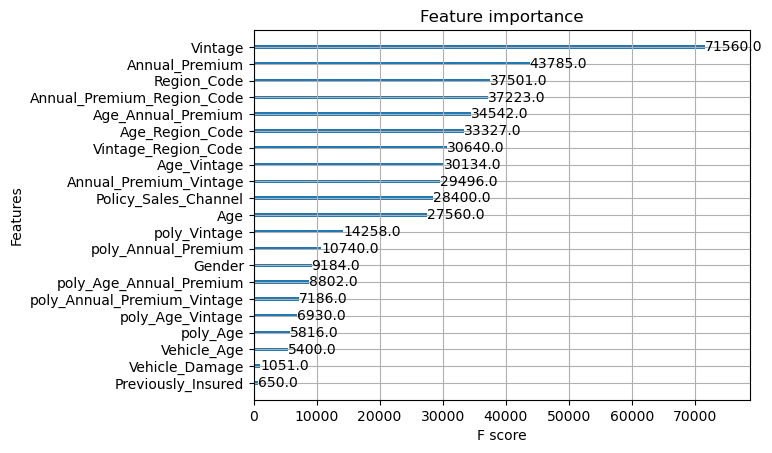

In [17]:
from xgboost import plot_importance

# Plot feature importances
plt.figure(figsize=(10, 8))
plot_importance(final_model, max_num_features=40)
# adjust max_num_features to your need
plt.show()
